In [0]:
# Train and Test ( Team. NMSP )

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
# 배치 사이즈를 결정하기 위한 함수
def next_batch(num, data, labels):
  idx = np.arange(0 , len(data))
  np.random.shuffle(idx)
  idx = idx[:num]
  data_shuffle = [data[i] for i in idx]
  labels_shuffle = [labels[i] for i in idx]

  return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [25]:
# 전처리 한 데이터를 불러온다.
X_set=np.load('entire_data.npy')
y_set=np.load('entire_label.npy')

X_set.shape, y_set.shape

((10618, 32, 32, 3), (10618, 1))

In [0]:
idx = np.arange(0 , len(y_set)) # Training Set, Validation Set 으로 나누기 위해 랜덤하게 나눔.
np.random.shuffle(idx)

X_set_shuffle=np.asarray([X_set[i] for i in idx])
y_set_shuffle=np.asarray([y_set[i] for i in idx])


X_size=X_set.shape[0]
test_size=int(X_size*0.2)


X_train=X_set_shuffle[test_size:]
X_test=X_set_shuffle[:test_size]

y_train=y_set_shuffle[test_size:]
y_test=y_set_shuffle[:test_size]

X_train.shape, y_train.shape, X_test.shape, y_test.shape


np.save("test_data.npy",X_test)
np.save("test_label.npy",y_test)

In [0]:
training_epochs = 20000 # 학습횟수
learning_rate = 1e-3 # 학습률

In [0]:
g1=tf.Graph() # 모델 생성하기.

with g1.as_default():
  X=tf.placeholder(tf.float32,[None,32,32,3])
  Y=tf.placeholder(tf.float32,[None,153])
  
  keep_prob=tf.placeholder(tf.float32)
  y_train_one_hot = tf.squeeze(tf.one_hot(y_train, 153),axis=1)
  y_test_one_hot = tf.squeeze(tf.one_hot(y_test, 153),axis=1)
  
  W_conv1 = tf.Variable(tf.truncated_normal(shape=[5, 5, 3, 64], stddev=5e-2))
  b_conv1 = tf.Variable(tf.constant(0.1, shape=[64]))
  h_conv1 = tf.nn.relu(tf.nn.conv2d(X, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

  # 첫번째 Pooling layer
  h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

  # 두번째 Convolutional layer - 32개의 특징들(feature)을 64개의 특징들로 맵핑.
  W_conv2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 64, 64], stddev=5e-2))
  b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))
  h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

  # 두번째 Pooling layer.
  h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

  # 세번째 Convolutional layer
  W_conv3 = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], stddev=5e-2))
  b_conv3 = tf.Variable(tf.constant(0.1, shape=[128]))
  h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, W_conv3, strides=[1, 1, 1, 1], padding='SAME') + b_conv3)

  # 네번째 Convolutional layer
  W_conv4 = tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 128], stddev=5e-2))
  b_conv4 = tf.Variable(tf.constant(0.1, shape=[128])) 
  h_conv4 = tf.nn.relu(tf.nn.conv2d(h_conv3, W_conv4, strides=[1, 1, 1, 1], padding='SAME') + b_conv4)

  # 다섯번째 Convolutional layer
  W_conv5 = tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 128], stddev=5e-2))
  b_conv5 = tf.Variable(tf.constant(0.1, shape=[128]))
  h_conv5 = tf.nn.relu(tf.nn.conv2d(h_conv4, W_conv5, strides=[1, 1, 1, 1], padding='SAME') + b_conv5)

  # Fully Connected Layer 1 - 2번의 Downsampling 이후, 32x32 이미지는 8x8x128 특징맵으로 형성됨
  # 이를 384개의 특징들로 맵핑
  W_fc1 = tf.Variable(tf.truncated_normal(shape=[8 * 8 * 128, 384], stddev=5e-2))
  b_fc1 = tf.Variable(tf.constant(0.1, shape=[384]))

  h_conv5_flat = tf.reshape(h_conv5, [-1, 8*8*128])
  h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

  # Dropout - co-adaptation을 방지하기 위해 사용
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob) 

  # Fully Connected Layer 2 - 384개의 특징들을 153개의 클래스로 맵핑
  W_fc2 = tf.Variable(tf.truncated_normal(shape=[384, 153], stddev=5e-2))
  b_fc2 = tf.Variable(tf.constant(0.1, shape=[153]))
  logits = tf.matmul(h_fc1_drop,W_fc2) + b_fc2
  y_pred = tf.nn.softmax(logits)
  
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits))
  train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

  correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(Y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  
  init = tf.global_variables_initializer()
  saver = tf.train.Saver()

Test Accuracy:  0.92275


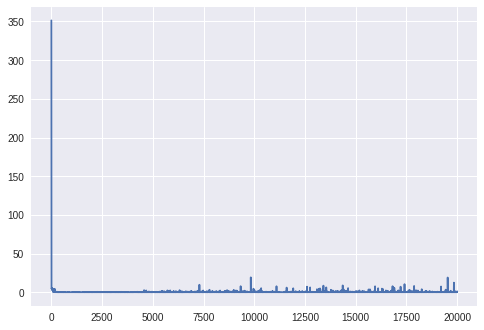

In [30]:
cost_history=[]

with tf.Session(graph=g1) as sess:
    sess.run(init)
    
    for epoch in range(training_epochs):
      batch=next_batch(500,X_train,y_train_one_hot.eval())
      
      _,cost=sess.run([train_step,loss],feed_dict={X:batch[0],Y:batch[1],keep_prob:1.0}) # 드롭아웃이 없는 경우
      cost_history.append(cost)
    
      sess.run(train_step, feed_dict={X: batch[0], Y: batch[1], keep_prob: 0.8}) # 드롭아웃 있는 경우로 재학습.
    
    
    
    

    print('Test Accuracy: ',round(sess.run(accuracy,feed_dict={X:X_test,Y:y_test_one_hot.eval(),keep_prob:1.0}),5))
    
    saver.save(sess, "ckpt/model_cnn.ckpt") # CheckPoint File을 저장한다.
    sess.close()
    
    
plt.plot(cost_history)
